In [1]:
import yfinance as yf
import pandas as pd
import talib
from sklearn.preprocessing import MinMaxScaler

In [9]:
import yfinance as yf
import numpy as np
import talib
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess_data(data):
    """
    Preprocesses the data by applying log transformation and standardization.
    Args:
        data (pandas.Series): The input dataset.
    Returns:
        numpy.ndarray: Scaled and preprocessed features.
        StandardScaler: Scaler used to standardize the data.
    """
    log_data = np.log(data)  # Log transformation
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(log_data.values.reshape(-1, 1))
    return data_scaled, scaler

# Fetch Nifty50 data for the past 10 years
nifty50_symbol = "^NSEI"
nifty50_data = yf.download(nifty50_symbol, start="2014-01-01", end="2025-07-26")

# Calculate Open-Close and High-Low Averages
nifty50_data['Open_Close_Avg'] = (nifty50_data['Open'] + nifty50_data['Close']) / 2
nifty50_data['High_Low_Avg'] = (nifty50_data['High'] + nifty50_data['Low']) / 2

# Calculate returns
for days in [5, 15, 30, 60]:
    nifty50_data[f'Open_Close_{days}d'] = nifty50_data['Open_Close_Avg'].pct_change(days)
    nifty50_data[f'High_Low_{days}d'] = nifty50_data['High_Low_Avg'].pct_change(days)

nifty50_data['NSEI_Daily_Return'] = nifty50_data['Close'].pct_change()

# Fetch INR-USD data for the past 10 years
inr_usd_symbol = "INRUSD=X"  # Correct ticker for INR-USD exchange rate
inr_usd_data = yf.download(inr_usd_symbol, start="2014-01-01", end="2025-07-26")
inr_usd_data['INRUSD_X'] = inr_usd_data['Close']

# Compute RSI (14-day)
nifty50_data['RSI'] = talib.RSI(nifty50_data['Close'].astype(float).values.flatten(), timeperiod=14)

# Compute OBV
nifty50_data['OBV'] = talib.OBV(nifty50_data['Close'].astype(float).values.flatten(), 
                                nifty50_data['Volume'].astype(float).values.flatten())

# Normalize RSI (-0.5 to 0.5) and OBV (-1 to 1)
rsi_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
obv_scaler = MinMaxScaler(feature_range=(-1, 1))

nifty50_data['RSI_Normalized'] = rsi_scaler.fit_transform(nifty50_data[['RSI']])
nifty50_data['OBV_Normalized'] = obv_scaler.fit_transform(nifty50_data[['OBV']])

# Apply preprocessing to Close prices
# nifty50_data['Close_Preprocessed'], close_scaler = preprocess_data(nifty50_data['Close'])

# Select relevant columns
nifty50_returns_data = nifty50_data[['Open_Close_5d', 'Open_Close_15d', 'Open_Close_30d', 'Open_Close_60d', 
                                     'High_Low_5d', 'High_Low_15d', 'High_Low_30d', 'High_Low_60d', 
                                     'RSI_Normalized', 'OBV_Normalized', 'Close', 'NSEI_Daily_Return']]
inr_usd_returns_data = inr_usd_data[['INRUSD_X']]

# Merge datasets based on Date index
Main_dataset = pd.merge(inr_usd_returns_data, nifty50_returns_data, left_index=True, right_index=True, how='inner')

# Drop NaN values
Main_dataset.dropna(inplace=True)

# Reset Index
Main_dataset.reset_index(inplace=True)

# Display result
print(Main_dataset.head())

# Save to CSV
Main_dataset.to_csv('../dataset/Temp_dataset_files/Main_dataset_with_OBV_RSI.csv', index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Date  INRUSD_X Open_Close_5d Open_Close_15d Open_Close_30d  \
Ticker                                                                    
0      2014-04-01  0.016669      0.023646       0.032359       0.112659   
1      2014-04-02  0.016728      0.022176       0.035320       0.119122   
2      2014-04-03  0.016695      0.019110       0.037939       0.107371   
3      2014-04-04  0.016559      0.005030       0.034760       0.093726   
4      2014-04-07  0.016759     -0.002834       0.033807       0.095813   

Price  Open_Close_60d High_Low_5d High_Low_15d High_Low_30d High_Low_60d  \
Ticker                                                                     
0            0.074119    0.020342     0.027445     0.109404     0.066677   
1            0.089028    0.021127     0.032932     0.120098     0.088288   
2            0.088287    0.015083     0.033775     0.103629     0.087027   
3            0.086531    0.006039     0.029828     0.092861     0.085778   
4            0.083

In [10]:
Main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   (Date, )               2775 non-null   datetime64[ns]
 1   (INRUSD_X, )           2775 non-null   float64       
 2   (Open_Close_5d, )      2775 non-null   float64       
 3   (Open_Close_15d, )     2775 non-null   float64       
 4   (Open_Close_30d, )     2775 non-null   float64       
 5   (Open_Close_60d, )     2775 non-null   float64       
 6   (High_Low_5d, )        2775 non-null   float64       
 7   (High_Low_15d, )       2775 non-null   float64       
 8   (High_Low_30d, )       2775 non-null   float64       
 9   (High_Low_60d, )       2775 non-null   float64       
 10  (RSI_Normalized, )     2775 non-null   float64       
 11  (OBV_Normalized, )     2775 non-null   float64       
 12  (Close, ^NSEI)         2775 non-null   float64       
 13  (NS

In [11]:
import os
import pandas as pd

# Define the folder containing all India VIX files
folder_path = "../dataset/Temp_dataset_files/india_vix/"
output_file = "../dataset/Temp_dataset_files/india_vix_2014_2025.csv"

# List all CSV files in the folder
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_files.sort()  # Ensure files are processed in order

# Initialize an empty list to store DataFrames
dataframes = []

for file in all_files:
    file_path = os.path.join(folder_path, file)
    
    # Read CSV and strip spaces from column names
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove spaces from column names
    
    # Keep only 'Date' and 'Close' columns
    if 'Date' in df.columns and 'Close' in df.columns:
        df = df[['Date', 'Close']]
        
        # Specify date format explicitly: 'DD-MMM-YYYY'
        df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y', errors='coerce')  # Convert to datetime
        dataframes.append(df)
    else:
        print(f"❌ Skipping {file}: 'Date' or 'Close' column missing.")

# Concatenate all DataFrames
if dataframes:
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    # Sort data by Date
    merged_df = merged_df.sort_values(by='Date')

    # Calculate the percentage change of the 'Close' column
    merged_df['IND_VIX'] = merged_df['Close'].pct_change() 
    
    # Save to a new CSV file
    merged_df.to_csv(output_file, index=False)
    print(f"✅ Merged India VIX data saved to: {output_file}")
else:
    print("❌ No valid files found. Check if 'Date' and 'Close' columns exist in your CSV files.")

✅ Merged India VIX data saved to: ../dataset/Temp_dataset_files/india_vix_2014_2025.csv


In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2864 non-null   datetime64[ns]
 1   Close    2864 non-null   float64       
 2   IND_VIX  2863 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 67.2 KB


In [13]:
import pandas as pd

# Load Main dataset and India VIX data
main_dataset_path = '../dataset/Temp_dataset_files/Main_dataset_with_OBV_RSI.csv'
indiavix_path = '../dataset/Temp_dataset_files/india_vix_2014_2025.csv'

main_df = pd.read_csv(main_dataset_path)
indiavix_df = pd.read_csv(indiavix_path)

# Ensure Date columns are in datetime format
main_df['Date'] = pd.to_datetime(main_df['Date'], errors='coerce')
indiavix_df['Date'] = pd.to_datetime(indiavix_df['Date'], errors='coerce')

# Merge datasets on the 'Date' column
merged_df = pd.merge(main_df, indiavix_df[['Date', 'IND_VIX']], on='Date', how='inner')

# Ensure NSEI_Daily_Return is at the end of the dataset
columns = [col for col in merged_df.columns if col != 'NSEI_Daily_Return']  # Exclude 'NSEI_Daily_Return'
columns.append('NSEI_Daily_Return')  # Append it at the end
merged_df = merged_df[columns]

# Save the combined dataset to a new CSV
output_path = '../dataset/Combined_Main_India_Vix.csv'
merged_df.to_csv(output_path, index=False)

print(f"✅ Merged dataset saved to: {output_path}")

✅ Merged dataset saved to: ../dataset/Combined_Main_India_Vix.csv


In [15]:
import yfinance as yf

indiavix_symbol = "^INDIAVIX"
indiavix_data = yf.download(indiavix_symbol, start="2014-01-01")

print(indiavix_data.columns)
print(indiavix_data.tail())

[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', '^INDIAVIX'),
            (  'High', '^INDIAVIX'),
            (   'Low', '^INDIAVIX'),
            (  'Open', '^INDIAVIX'),
            ('Volume', '^INDIAVIX')],
           names=['Price', 'Ticker'])
Price          Close      High       Low      Open    Volume
Ticker     ^INDIAVIX ^INDIAVIX ^INDIAVIX ^INDIAVIX ^INDIAVIX
Date                                                        
2025-07-21     11.20     11.94     11.09     11.39         0
2025-07-22     10.75     11.23     10.69     11.20         0
2025-07-23     10.52     10.75     10.22     10.75         0
2025-07-24     10.72     11.11      9.87     10.52         0
2025-07-25     11.28     11.58     10.61     10.72         0


In [16]:
indiavix_data

Price,Close,High,Low,Open,Volume
Ticker,^INDIAVIX,^INDIAVIX,^INDIAVIX,^INDIAVIX,^INDIAVIX
Date,,,,,
2014-01-01,15.580000,15.580000,15.10,15.120000,0
2014-01-02,16.549999,16.969999,15.33,15.580000,0
2014-01-03,15.870000,17.320000,15.79,16.549999,0
2014-01-06,16.500000,16.910000,15.87,15.870000,0
2014-01-07,16.320000,16.910000,16.10,16.500000,0
...,...,...,...,...,...
2025-07-21,11.200000,11.940000,11.09,11.390000,0
2025-07-22,10.750000,11.230000,10.69,11.200000,0


### Dataset Creation with india vix from yfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


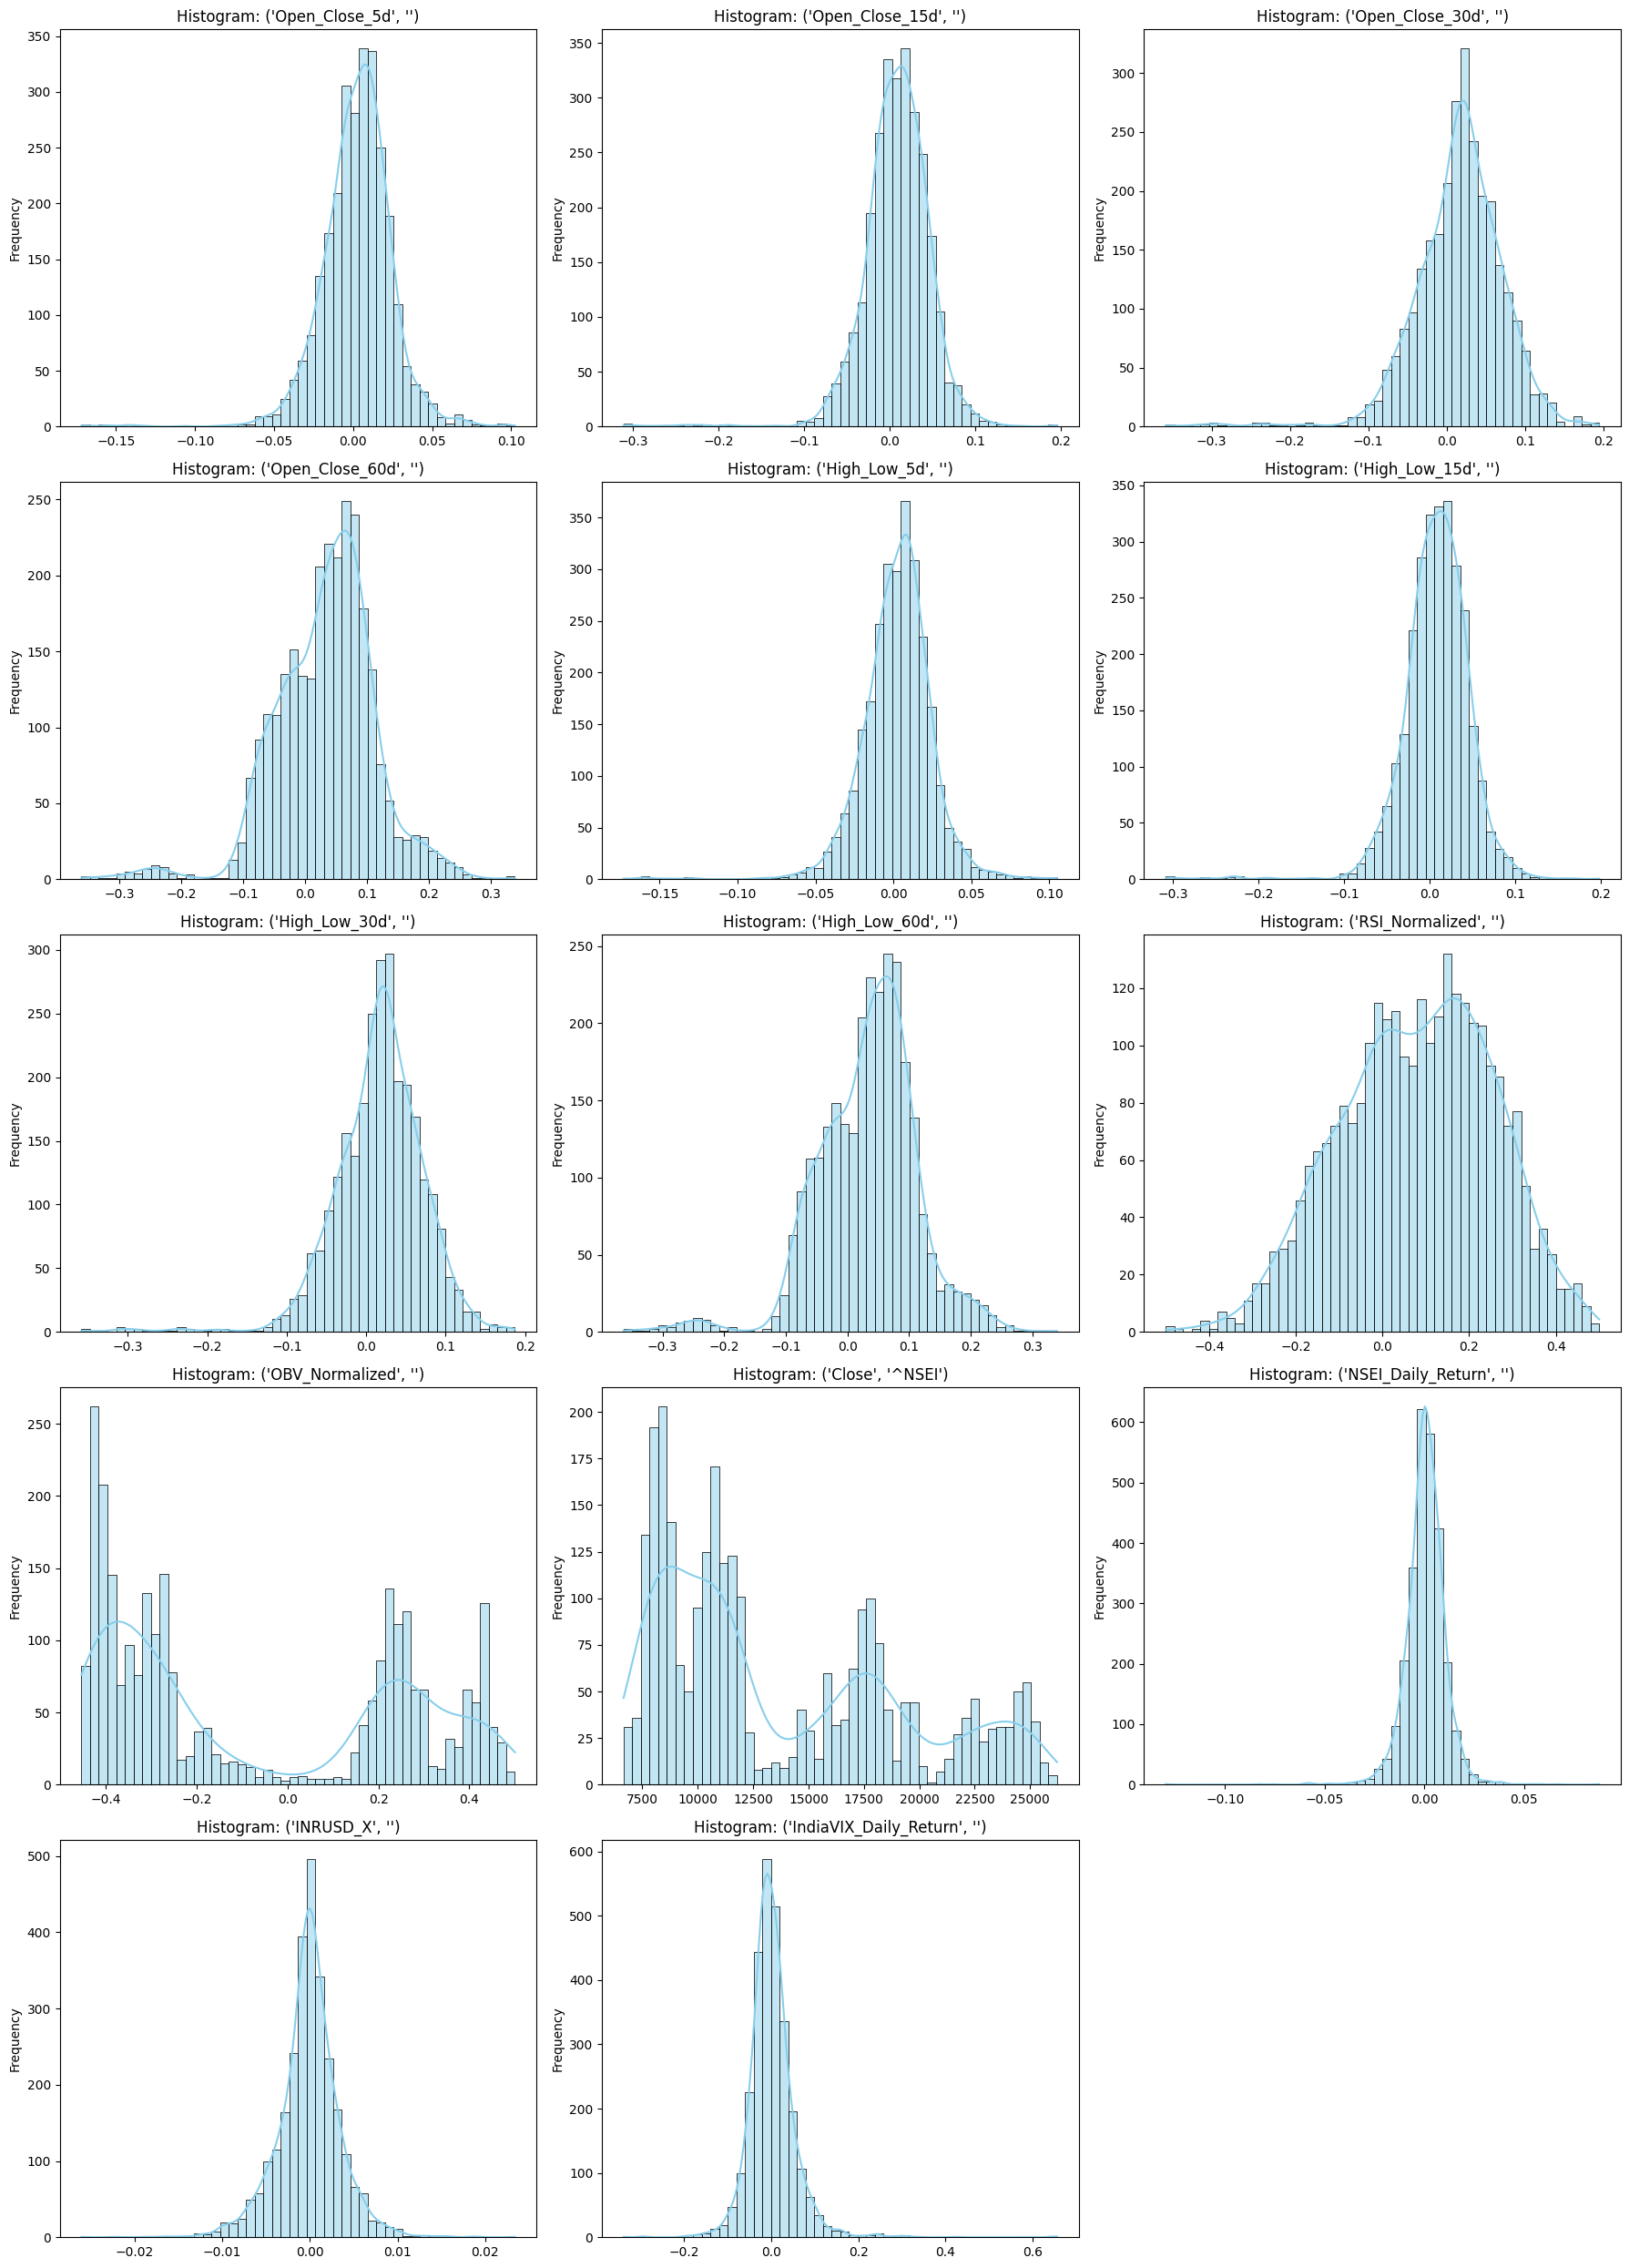

In [3]:
import yfinance as yf
import numpy as np
import talib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# -------------------- Function --------------------

def preprocess_data(data):
    log_data = np.log(data)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(log_data.values.reshape(-1, 1))
    return data_scaled, scaler

# -------------------- 1. Fetch Data --------------------

# Nifty 50
nifty50_data = yf.download("^NSEI", start="2014-01-01", end="2025-07-26")

# INR/USD
inr_usd_data = yf.download("INRUSD=X", start="2014-01-01", end="2025-07-26")
inr_usd_data['INRUSD_X'] = inr_usd_data['Close'].pct_change()

# India VIX
indiavix_data = yf.download("^INDIAVIX", start="2014-01-01", end="2025-07-26")
indiavix_data['IndiaVIX_Daily_Return'] = indiavix_data['Close'].pct_change()

# -------------------- 2. Feature Engineering (Nifty 50) --------------------

# Average prices
nifty50_data['Open_Close_Avg'] = (nifty50_data['Open'] + nifty50_data['Close']) / 2
nifty50_data['High_Low_Avg'] = (nifty50_data['High'] + nifty50_data['Low']) / 2

# Multi-period returns
for days in [5, 15, 30, 60]:
    nifty50_data[f'Open_Close_{days}d'] = nifty50_data['Open_Close_Avg'].pct_change(days)
    nifty50_data[f'High_Low_{days}d'] = nifty50_data['High_Low_Avg'].pct_change(days)

# Daily return
nifty50_data['NSEI_Daily_Return'] = nifty50_data['Close'].pct_change()

# -------------------- 3. Technical Indicators --------------------

nifty50_data['RSI'] = talib.RSI(nifty50_data['Close'].astype(float).values.flatten(), timeperiod=14)
nifty50_data['OBV'] = talib.OBV(nifty50_data['Close'].astype(float).values.flatten(), 
                                nifty50_data['Volume'].astype(float).values.flatten())

# Normalize RSI and OBV
rsi_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
obv_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))

nifty50_data['RSI_Normalized'] = rsi_scaler.fit_transform(nifty50_data[['RSI']])
nifty50_data['OBV_Normalized'] = obv_scaler.fit_transform(nifty50_data[['OBV']])

# -------------------- 4. Merge Final Dataset --------------------

# Merge on index (Date)
df = pd.concat([
    nifty50_data[[
        'Open_Close_5d', 'Open_Close_15d', 'Open_Close_30d', 'Open_Close_60d',
        'High_Low_5d', 'High_Low_15d', 'High_Low_30d', 'High_Low_60d',
        'RSI_Normalized', 'OBV_Normalized', 'Close', 'NSEI_Daily_Return'
    ]],
    inr_usd_data[['INRUSD_X']],
    indiavix_data[['IndiaVIX_Daily_Return']]
], axis=1)

df.dropna(inplace=True)

# -------------------- 5. Plot Histograms for All Features --------------------

numeric_cols = df.select_dtypes(include=np.number).columns

# Set up the grid
num_cols = len(numeric_cols)
cols = 3
rows = (num_cols // cols) + int(num_cols % cols != 0)

plt.figure(figsize=(18, 5 * rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=50, color='skyblue')
    plt.title(f'Histogram: {col}')
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
import yfinance as yf
import numpy as np
import talib
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess_data(data):
    """
    Applies log transformation and standard scaling.
    Args:
        data (pandas.Series): Series of prices.
    Returns:
        numpy.ndarray: Scaled and transformed array.
        StandardScaler: The scaler object used.
    """
    log_data = np.log(data)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(log_data.values.reshape(-1, 1))
    return data_scaled, scaler

# -------------------- 1. Fetch Data --------------------

# Nifty 50
nifty50_symbol = "^NSEI"
nifty50_data = yf.download(nifty50_symbol, start="2014-01-01", end="2025-07-26")

# INR/USD
inr_usd_symbol = "INRUSD=X"
inr_usd_data = yf.download(inr_usd_symbol, start="2014-01-01", end="2025-07-26")
inr_usd_data['INRUSD_X'] = inr_usd_data['Close'].pct_change()

# India VIX
indiavix_symbol = "^INDIAVIX"
indiavix_data = yf.download(indiavix_symbol, start="2014-01-01", end="2025-07-26")
indiavix_data['IndiaVIX_Daily_Return'] = indiavix_data['Close'].pct_change()

# -------------------- 2. Feature Engineering (Nifty 50) --------------------

# Average price features
nifty50_data['Open_Close_Avg'] = (nifty50_data['Open'] + nifty50_data['Close']) / 2
nifty50_data['High_Low_Avg'] = (nifty50_data['High'] + nifty50_data['Low']) / 2

# Multi-period returns
for days in [5, 15, 30, 60]:
    nifty50_data[f'Open_Close_{days}d'] = nifty50_data['Open_Close_Avg'].pct_change(days)
    nifty50_data[f'High_Low_{days}d'] = nifty50_data['High_Low_Avg'].pct_change(days)

# Daily return
nifty50_data['NSEI_Daily_Return'] = nifty50_data['Close'].pct_change()

# -------------------- 3. Technical Indicators --------------------

# RSI (14)
nifty50_data['RSI'] = talib.RSI(nifty50_data['Close'].astype(float).values.flatten(), timeperiod=14)

# OBV
nifty50_data['OBV'] = talib.OBV(nifty50_data['Close'].astype(float).values.flatten(), 
                                nifty50_data['Volume'].astype(float).values.flatten())

# Normalize RSI and OBV
rsi_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
obv_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))

nifty50_data['RSI_Normalized'] = rsi_scaler.fit_transform(nifty50_data[['RSI']])
nifty50_data['OBV_Normalized'] = obv_scaler.fit_transform(nifty50_data[['OBV']])

# -------------------- 4. Prepare Dataset --------------------

# Nifty 50 features
nifty50_returns_data = nifty50_data[[
    'Open_Close_5d', 'Open_Close_15d', 'Open_Close_30d', 'Open_Close_60d',
    'High_Low_5d', 'High_Low_15d', 'High_Low_30d', 'High_Low_60d',
    'RSI_Normalized', 'OBV_Normalized', 'Close', 'NSEI_Daily_Return'
]]

# INRUSD data
inr_usd_returns_data = inr_usd_data[['INRUSD_X']]

# India VIX daily return
vix_return_data = indiavix_data[['IndiaVIX_Daily_Return']]

# -------------------- 5. Merge All Data --------------------

# Merge INR/USD into Nifty50 (preserve Nifty50's dates)
Main_dataset = pd.merge(nifty50_returns_data, inr_usd_returns_data, 
                        left_index=True, right_index=True, how='left')

# Merge India VIX daily return (still preserving Nifty50's dates)
Main_dataset = pd.merge(Main_dataset, vix_return_data, 
                        left_index=True, right_index=True, how='left')

# Fix: flatten MultiIndex columns if present
if isinstance(Main_dataset.columns[0], tuple):
    Main_dataset.columns = ['_'.join([str(i) for i in col if i]) for col in Main_dataset.columns]

# Drop rows with any missing values
Main_dataset.dropna(inplace=True)

# Reset index to make 'Date' a column
Main_dataset.reset_index(inplace=True)

# Reorder: move INRUSD and VIX columns to the front
priority_cols = [col for col in ['INRUSD_X', 'IndiaVIX_Daily_Return'] if col in Main_dataset.columns]
other_cols = [col for col in Main_dataset.columns if col not in priority_cols and col != 'Date']
Main_dataset = Main_dataset[['Date'] + priority_cols + other_cols]

# -------------------- 6. Save --------------------

# Save to CSV
Main_dataset.to_csv('Dataset.csv', index=False)

# Display sample
print(Main_dataset.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

        Date  INRUSD_X  IndiaVIX_Daily_Return  Open_Close_5d  Open_Close_15d  \
0 2014-04-01 -0.002500              -0.043016       0.023646        0.032359   
1 2014-04-02  0.003513               0.025133       0.022176        0.035320   
2 2014-04-03 -0.001970               0.042433       0.019110        0.037939   
3 2014-04-04 -0.008147               0.026232       0.005030        0.034760   
4 2014-04-07  0.012066               0.099603      -0.002834        0.033807   

   Open_Close_30d  Open_Close_60d  High_Low_5d  High_Low_15d  High_Low_30d  \
0        0.112659        0.074119     0.020342      0.027445      0.109404   
1        0.119122        0.089028     0.021127      0.032932      0.120098   
2        0.107371        0.088287     0.015083      0.033775      0.103629   
3        0.093726        0.086531     0.006039      0.029828      0.092861   
4        0.095813        0.083921    -0.001262      0.032769      0.094961   

   High_Low_60d  RSI_Normalized  OBV_Normalized  C

In [6]:
print("Nifty dates:", len(nifty50_returns_data))
print("INRUSD dates:", len(inr_usd_returns_data))
print("VIX dates:", len(vix_return_data))

Nifty dates: 2740
INRUSD dates: 2906
VIX dates: 2732


In [9]:
import yfinance as yf
import numpy as np
import talib
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os

# -------------------- Configuration --------------------
DATA_PATH = 'Dataset.csv'
SAVE_PATH = DATA_PATH
FETCH_PADDING_DAYS = 100  # Use last 100 rows to ensure RSI/OBV continuity

# -------------------- Helper: Preprocessing --------------------
def preprocess_data(data):
    log_data = np.log(data)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(log_data.values.reshape(-1, 1))
    return data_scaled, scaler

# -------------------- 1. Load Existing Dataset --------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

existing_df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
last_date = existing_df['Date'].max().date()
print(f"✅ Last available date in dataset: {last_date}")

# -------------------- 2. Fetch New Market Data --------------------
start_date = (last_date - timedelta(days=FETCH_PADDING_DAYS)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"📥 Fetching data from {start_date} to {end_date}...")
nifty = yf.download("^NSEI", start=start_date, end=end_date)
inrusd = yf.download("INRUSD=X", start=start_date, end=end_date)
vix = yf.download("^INDIAVIX", start=start_date, end=end_date)

nifty['Open_Close_Avg'] = (nifty['Open'] + nifty['Close']) / 2
nifty['High_Low_Avg'] = (nifty['High'] + nifty['Low']) / 2

# Multi-period returns
for days in [5, 15, 30, 60]:
    nifty[f'Open_Close_{days}d'] = nifty['Open_Close_Avg'].pct_change(days)
    nifty[f'High_Low_{days}d'] = nifty['High_Low_Avg'].pct_change(days)

nifty['NSEI_Daily_Return'] = nifty['Close'].pct_change()

# RSI and OBV
nifty['RSI'] = talib.RSI(nifty['Close'].astype(float).values.flatten(), timeperiod=14)
nifty['OBV'] = talib.OBV(nifty['Close'].astype(float).values.flatten(), 
                         nifty['Volume'].astype(float).values.flatten())

# Normalize RSI and OBV
rsi_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
nifty['RSI_Normalized'] = rsi_scaler.fit_transform(nifty[['RSI']])

obv_scaler = MinMaxScaler(feature_range=(-1, 1))
nifty['OBV_Normalized'] = obv_scaler.fit_transform(nifty[['OBV']])

# INR/USD Close
inrusd['INRUSD_X'] = inrusd['Close']

# India VIX daily return
vix['IndiaVIX_Daily_Return'] = vix['Close'].pct_change()

# -------------------- 3. Prepare Final Data --------------------
nifty_features = nifty[[
    'Open_Close_5d', 'Open_Close_15d', 'Open_Close_30d', 'Open_Close_60d',
    'High_Low_5d', 'High_Low_15d', 'High_Low_30d', 'High_Low_60d',
    'RSI_Normalized', 'OBV_Normalized', 'Close', 'NSEI_Daily_Return']]

combined_df = pd.merge(nifty_features, inrusd[['INRUSD_X']],
                       left_index=True, right_index=True, how='left')
combined_df = pd.merge(combined_df, vix[['IndiaVIX_Daily_Return']],
                       left_index=True, right_index=True, how='left')
combined_df.dropna(inplace=True)

# Move index to Date column
combined_df.reset_index(inplace=True)  # 'Date' column now exists

# -------------------- 4. Final Column Cleanup --------------------
# Flatten multi-index column names if any
combined_df.columns = [col if not isinstance(col, tuple) else col[0] for col in combined_df.columns]

# Drop any stray/unnamed columns
combined_df = combined_df.loc[:, ~combined_df.columns.str.contains("^Unnamed")]

# Ensure consistent column order
expected_order = [
    'Date', 'INRUSD_X', 'IndiaVIX_Daily_Return', 
    'Open_Close_5d', 'Open_Close_15d', 'Open_Close_30d', 'Open_Close_60d',
    'High_Low_5d', 'High_Low_15d', 'High_Low_30d', 'High_Low_60d',
    'RSI_Normalized', 'OBV_Normalized', 'Close', 'NSEI_Daily_Return'
]
combined_df = combined_df[expected_order]

# -------------------- 5. Append Only New Rows --------------------
new_data = combined_df[combined_df['Date'] > pd.to_datetime(last_date)]
print(f"🆕 New rows to append: {len(new_data)}")

if not new_data.empty:
    updated_df = pd.concat([existing_df, new_data], ignore_index=True)
    updated_df.to_csv(SAVE_PATH, index=False)
    print(f"✅ Dataset updated with {len(new_data)} new rows.")
else:
    print("📌 No new data to update.")

[*********************100%***********************]  1 of 1 completed

✅ Last available date in dataset: 2025-07-25
📥 Fetching data from 2025-04-16 to 2025-07-31...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

🆕 New rows to append: 3
✅ Dataset updated with 3 new rows.
